In [49]:
import numpy as np
import scipy.integrate as integrate
from astropy.cosmology import WMAP9 as cosmo
from astropy import constants
from astropy import units as u
import scipy.interpolate
import time
from scipy.optimize import curve_fit
import math
from numba import njit

In [226]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.ticker as mticker
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
%matplotlib inline
mpl.style.use('default')

myColors = ["#009E73", "#0072B2", "#CC79A7", "#D55E00", "#56B4E9", "#F0E442", "#E69F00", "#000000"]
colors= ["white", myColors[4], myColors[1], myColors[0], myColors[5], myColors[6], myColors[3]]
myNodes = [0.0, 0.1, 0.2, 0.35, 0.5, 0.85, 1.0]
myCmap = mpl.colors.LinearSegmentedColormap.from_list("mycmap", list(zip(myNodes, colors)))

colorsLog= ["white",  myColors[4], myColors[1], myColors[6], myColors[3], myColors[3]]
myNodesLog = [0.0, 0.1 , 0.2, 0.36, 0.6, 1]
myCmapLog = mpl.colors.LinearSegmentedColormap.from_list("mycmapLog", list(zip(myNodesLog, colorsLog)))

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 15

mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams.update({
	'font.family':'serif',
	'mathtext.fontset' : 'cm',
	'mathtext.rm': 'serif',
	'font.weight': 'normal',
	})
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 
plt.rcParams.update({'font.size': 15})

mpl.rcParams['axes.prop_cycle'] = cycler(color=myColors)

path_image = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/images/'

In [51]:

def RescalingCenters(DataSet, Nbins, Bins_limit=None):

    if Bins_limit==None:
        bins_max=DataSet[-1][0]
        bins_min=DataSet[0][0]
    else:
        bins_max=Bins_limit[1]
        bins_min=Bins_limit[0]
        
    x_data=DataSet[:,0]
    bins_edges = np.logspace(np.log10(bins_min), np.log10(bins_max), Nbins+1)
    bins_centers = np.array([0.5 * (bins_edges[i] + bins_edges[i+1]) for i in range(Nbins)])
    y_data=DataSet[:,1]

    y_stackable = np.zeros(Nbins)

    for j in range(Nbins):
        for i in range(len(x_data)):
            if (x_data[i]<bins_edges[j+1])and(x_data[i]>bins_edges[j]):
                x_data[i]=bins_centers[j]
                y_stackable[j]=round(y_data[i])
            else:
                pass
        
    return bins_edges, bins_centers,  y_stackable

In [52]:
def DataStack(DataSets, Nbins, Bins_limit=None):

    if Bins_limit==None:
        a=np.empty(len(DataSets), dtype=object)
        for i in range(len(DataSets)):
            a[i] = DataSets[i][:,0]
        a=np.concatenate(a)
        
        bins_max=max(a)

        bins_min=min(a)

        bins_limit=(bins_min, bins_max)
    else:
        bins_max=Bins_limit[1]
        bins_min=Bins_limit[0]


    y_stacked = np.zeros(Nbins)
    for i in range(len(DataSets)):

        bins_edges, bins_center, y_stackable = RescalingCenters(DataSets[i], Nbins, Bins_limit=(bins_min, bins_max))
        y_stacked += y_stackable
    

    return bins_edges, bins_center, y_stacked

In [53]:
pathfit_susa = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Susa2014/'
name_N_per_halo = 'Stars_per_minihalo'
N_per_halos = np.rint(np.genfromtxt(pathfit_susa + 'N_per_halos' +'.csv'))
x_bins=np.arange(1,7,1)


In [54]:
def PowerLaw(x, A, a):
    return A*np.exp(-x*a)

def PowerLaw_norm(x, A, a):
    N_NH = integrate.quad(PowerLaw, 0.5, 7.5, args=(A, a))[0]
    return A*np.exp(-x*a)/N_NH


In [55]:
x_fit_NH = np.arange(1, 7, 0.1)
sample=[]
popt, pcov = curve_fit(PowerLaw, x_bins, N_per_halos,  bounds=([18, 0], [30, 10]))
y_fit_NH = PowerLaw(x_fit_NH, *popt)
A, a = popt
N_tot = np.sum(N_per_halos)

Text(0, 0.5, 'Number of halo')

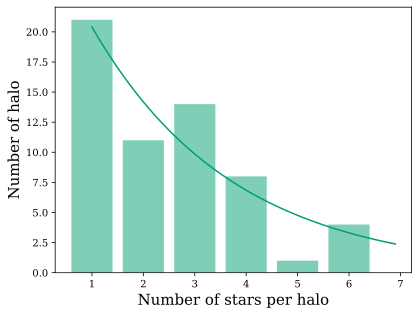

In [56]:
plt.bar(x_bins, N_per_halos, alpha = 0.5)
plt.plot(x_fit_NH, y_fit_NH, color=myColors[0])

plt.xlabel('Number of stars per halo')
plt.ylabel('Number of halo')

In [57]:
N_per_halos_z30 = np.array([0.8, 0.2, 0., 0., 0., 0.])
popt30, pcov30 = curve_fit(PowerLaw, x_bins, N_per_halos_z30,  bounds=([18, 0], [30, 10]))
y_fit_NH_30 = PowerLaw(x_fit_NH, *popt30)

A30, a30 = popt30

In [58]:
N_NH = integrate.quad(PowerLaw, 1, 7, args=(A, a))[0]
N_per_halos_z10 = N_per_halos/N_NH

popt10, pcov10 = curve_fit(PowerLaw_norm, x_bins, N_per_halos_z10,  bounds=([0, 0], [30, 10]))
y_fit_NH_10 = PowerLaw(x_fit_NH, *popt10)

A10, a10 = popt10

n = np.linspace(0.5, 7.5, 100)
N_star_prob = scipy.interpolate.interp1d(n, PowerLaw(n, A10, a10), kind='cubic')

In [59]:
def Az(z):
    # A_int = scipy.interpolate.UnivariateSpline((10, 30),(A10, A30))
    A_int =  scipy.interpolate.krogh_interpolate((10, 30),(A10, A30), z)
    return float(A_int)

def az(z):
    # a_int = scipy.interpolate.UnivariateSpline((10, 30),(a10, a30))
    a_int =  scipy.interpolate.krogh_interpolate((10, 30),(a10, a30), z)
    return float(a_int)

def PowerLaw_PDF_Z(n_s, z):
    def PowerLaw_z(n_s, z):
        A = Az(z)
        a = az(z)
        N_NH = integrate.quad(PowerLaw, 1, 7, args=(A, a))[0]
        return A*np.exp(-n_s*a)/N_NH
    v= np.vectorize(PowerLaw_z)
    return v(n_s, z)

In [60]:
def N_star_pdf(n_s):
    n = np.vectorize(N_star_prob)
    return n(n_s)

We want to build a monte carlo that return the number of star par mass of halos with an associated mass. 
To do so we needed the IMF of the halos, the distribution of stars in the halos and their IMFwe have now everything we wanted to perform this.

In [61]:
from PS_class import HaloMassFunction

In [295]:
HMF = HaloMassFunction(0, logmass_lim=(4, 20), Nbins=100)

gen = np.random.default_rng()

H_IMF = HMF.IMF

z = np.linspace(10, 30, 100)
Mh_interval=(10**4, 10**8)
m = np.logspace(np.log10(Mh_interval[0]), np.log10(Mh_interval[1]), 100)

In [296]:
xh, yh = np.meshgrid(m, z)

h = H_IMF(xh, yh)

In [291]:
h_inter = scipy.interpolate.interp2d(m, z, h, kind='cubic')

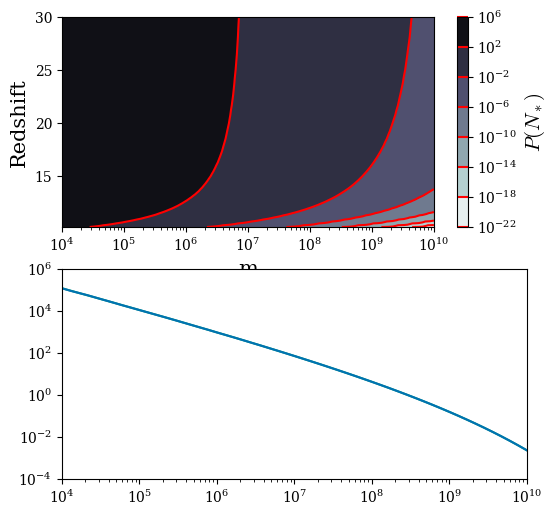

In [294]:
fig1, ax2 = plt.subplots(2, figsize=(6 , 6))

origin = 'lower'

CS = ax2[0].contourf(m, z, h_inter(m,z), cmap=plt.cm.bone_r, origin=origin, locator=mpl.ticker.LogLocator())

ax2[0].set_xlabel('m')
ax2[0].set_xscale('log')
ax2[0].set_ylabel('Redshift')
CS2 = ax2[0].contour(CS, levels=CS.levels[::1], colors='r', origin=origin)
cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('$P(N_*)$')
m2 = np.logspace(4, 15, 100)
ax2[1].plot(m2, h_inter(m2, 10))
ax2[1].set_xscale('log')
ax2[1].set_yscale('log')
ax2[1].plot(m2, H_IMF(m2, 10))
ax2[1].set_xscale('log')
ax2[1].set_yscale('log')

ax2[1].set_ylim(1e-4,1e6)
ax2[1].set_xlim(1e4,1e10)

cbar.add_lines(CS2)

In [66]:
def halo_PDF_norm(z):
    return integrate.quad(h_inter, Mh_interval[0], Mh_interval[1], args=(z), epsrel=1e-4, limit=1000)[0]

halo_PDF_norm(11)

6872449619.073117

In [67]:
from PS_class import GrowthFunction

GF = GrowthFunction()

In [68]:
from PS_class import Overdensities
O=Overdensities(0)
def derivative(M):
        sigma = O.S(M)
        sigma_plus = O.S(1.000000001*M)
        return (sigma_plus-sigma)/(0.000000001*M)

def M_finder(M0, sigma):
        return float(scipy.optimize.fsolve(lambda x: O.S(x)-sigma, M0))

m_finder =np.vectorize(M_finder)
        
def S_for_M(M, sigma_MF):
    return O.S(M)-sigma_MF



In [69]:
Mh_interval=(10**4, 10**8)
def HalosGenerator(M_max, z):

    norm = halo_PDF_norm(z)

    def pdf(m):
        return h_inter(m, z)/norm
    
    m_int = np.logspace(4, 10, 100)
    pdf_int = scipy.interpolate.interp1d(m_int, pdf(m_int))

    fmax=pdf_int(Mh_interval[0])+0.02*pdf_int(Mh_interval[0])
    x_output=np.array([])
    
    m=0
    t=[]
    while m<M_max:

        # t0 = time.time()
        # t.append(time.time()-t0)

        x = gen.uniform(*Mh_interval, 10000)
        y = gen.uniform(0, fmax, 10000)

        x_accepted = x[(y <= pdf_int(x))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        m+=np.sum(x_accepted)

        

        # if(ii>=100):
        #     t_tot =np.mean(t)*ninput
        #     print(" Time for 1 loop is approx:", np.mean(t)
        #         , "\n Comp is finished in ", t_tot, "s"
        #         , " = " , t_tot/60 , "min" )
    
    return x_output



In [70]:
h = HalosGenerator(1e9, 20)

In [71]:
len(h)

1837

In [72]:
def N_StarGenerator(m_Hs, f):

    fmax=N_star_pdf(0.5)+0.02*N_star_pdf(0.5)
    x_output=np.array([])
    y_output=np.array([])

    ninput=len(m_Hs)
    
    ii = 0
    t = []
    while ii<ninput:

        x = gen.uniform(0.5, 7.5, ninput)
        y = gen.uniform(0, fmax, ninput)

        x_accepted = x[(y <= N_star_pdf(x))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        y_accepted = y[(y <= N_star_pdf(x))]
        y_output = (np.append(y_output, y_accepted)).flatten()
        ii+=len(x_accepted)
        # print('N_star', ii)

        x_output = x_output[:ninput]
        y_output = y_output[:ninput]
        
    
    return (np.rint((m_Hs/10**6)**f*x_output)).astype(int)

    


In [73]:
def Gaussian(x, s, mu):
    return (1 / (s*np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * s**2))

In [74]:
def Double_Gaussian(x, s1, mu1, A1, s2, mu2, A2):
    return A1 * np.exp(-(x - mu1)**2 / (2 * s1**2)) + A2 * np.exp(-(x - mu2)**2 / (2 * s2**2))

In [75]:
def HistMaker(bar_edges, bar_centers, bar_Y):
    data = []
    for i in range(len(bar_edges)-1):
        ii=1
        l1= len(data)
        while ii<=bar_Y[i]:
            data.append(np.log10(bar_centers[i]))
            ii+=1
        l2 = len(data)
        # print(l2-l1, bar_Y[i], np.array(data)[l1:l2])
    return data

In [76]:
#Hirano 2015
name_Hirano2015 = ['Total', '10<z<14', '14<z<18', '18<z<22', '22<z<26', '26<z<30', 'Bins']

pathfit_Hirano2015= '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Hirano2015/'
Hirano2015 = np.empty(len(name_Hirano2015), dtype=object)
for i in range(len(name_Hirano2015)):
    Hirano2015[i] = np.genfromtxt(pathfit_Hirano2015 + name_Hirano2015[i] +'.csv', delimiter=';')

Nbins_Hirano2015 = len(Hirano2015[0])
Bins_Hirano2015_min = min(Hirano2015[-1][:,0])
Bins_Hirano2015_max = max(Hirano2015[-1][:,0])
Bins_limit_Hirano2015=(Bins_Hirano2015_min, Bins_Hirano2015_max)


Hirano2015_Y=np.empty(len(Hirano2015), dtype=object)
Hirano2015_edges = np.empty(len(Hirano2015), dtype=object)
Hirano2015_centers = np.empty(len(Hirano2015), dtype=object)
Data_Hirano2015 = np.empty(len(Hirano2015), dtype=object)

for i in range(len(Hirano2015)):
    Hirano2015_edges[i], Hirano2015_centers[i], Hirano2015_Y[i] = RescalingCenters(Hirano2015[i], Nbins_Hirano2015, Bins_limit=Bins_limit_Hirano2015)
    Data_Hirano2015[i]= HistMaker(Hirano2015_edges[i], Hirano2015_centers[i], Hirano2015_Y[i])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.9911086115606538, 2.324458683825721e-09)
[0.11683528 1.3816745  1.40116422 0.25327232 2.18074878 0.91478506]
(0.9401219023557018, 2.246588450197768e-09)
[0.14016337 2.         0.53677288 0.1554906  2.35955187 1.92820967]
[0.15636607 2.43724364]
[0.09545854 2.51981353]
[0.125979   2.52119741]


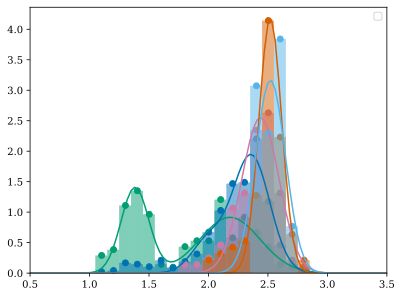

In [77]:
Hirano2015_popts = np.empty(5, dtype=object
                            )
for i in range(1, len(Data_Hirano2015)-1):
    mfit_pop3_h2015 = np.linspace(0.5, 3.5, 100)
    bin_entries, _, _  = plt.hist(Data_Hirano2015 [i], bins=np.linspace(np.log10(Bins_limit_Hirano2015[0]), np.log10(Bins_limit_Hirano2015[1]), 21), alpha = 0.5, density=True, color=myColors[i-1])   

    mask=(Hirano2015_Y[i]!=0)
    Hirano2015_centerf = np.log10(Hirano2015_centers[i])[mask]
    plt.scatter(np.log10(Hirano2015_centers[i])[mask], bin_entries[mask], color=myColors[i-1])


    if i<3:
        Hirano2015_popts[i-1], Hirano2015_pcov = curve_fit(Double_Gaussian, Hirano2015_centerf, bin_entries[mask], bounds=([0, 1, 0, 0, 2, 0],[1, 2, 10, 1, 3, 10]))
        s1, mu1, A1, s2, mu2, A2 = Hirano2015_popts[i-1]
        norm = integrate.quad(Double_Gaussian, 0.5, 3.5, args = (s1, mu1, A1, s2, mu2, A2, ))
        print(norm)
        plt.plot(mfit_pop3_h2015, Double_Gaussian(mfit_pop3_h2015, *Hirano2015_popts[i-1]), color=myColors[i-1])
    elif i>=3:
        Hirano2015_popts[i-1], Hirano2015_pcov = curve_fit(Gaussian, Hirano2015_centerf, bin_entries[mask], bounds=([0,2],[1, 3]))
        plt.plot(mfit_pop3_h2015, Gaussian(mfit_pop3_h2015, *Hirano2015_popts[i-1]), color=myColors[i-1])
    
    print(Hirano2015_popts[i-1]) 

# plt.ylim(1, 1000)
plt.xlim(0.5, 3.5)
# plt.yscale('log')
plt.legend()

In [233]:
10**1.37

23.442288153199225

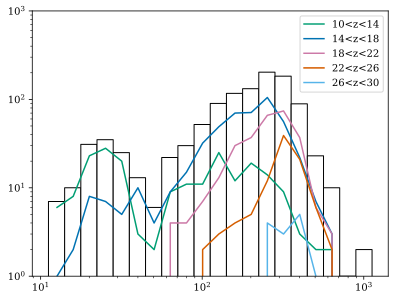

In [78]:
plt.bar(Hirano2015_edges[0][:-1], Hirano2015_Y[0], width=np.diff(Hirano2015_edges[i]), ec="k", align="edge", color='white')
for i in range(1, len(Hirano2015)-1):
    plt.plot(Hirano2015_centers[i], Hirano2015_Y[i], label=f'{name_Hirano2015[i]}')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1, 1000)
plt.legend()

In [79]:
s1, mu1, A1, s2, mu2, A2 = Hirano2015_popts[0]
norm1 = integrate.quad(Double_Gaussian, 0.5, 3.5, args = (s1, mu1, A1, s2, mu2, A2, ))[0]
s1, mu1, A1, s2, mu2, A2 = Hirano2015_popts[1]
norm2 = integrate.quad(Double_Gaussian, 0.5, 3.5, args = (s1, mu1, A1, s2, mu2, A2, ))[0]

def hirano2015_pdf(M, z):
    if 10<=z and z<14:
        return Double_Gaussian(np.log10(M), *Hirano2015_popts[0])/norm1
    elif 14<=z and z<18:
        return Double_Gaussian(np.log10(M), *Hirano2015_popts[1])/norm2
    elif 18<=z and z<22:
        return Gaussian(np.log10(M), *Hirano2015_popts[2])
    elif 22<=z and z<26:
        return Gaussian(np.log10(M), *Hirano2015_popts[3])
    elif 26<=z and z<=30:
        return Gaussian(np.log10(M), *Hirano2015_popts[4])

Hirano2015_pdf = np.vectorize(hirano2015_pdf)
    

    

In [80]:
pathfit_susa = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/Susa2014/'
name_susa = ['Bins edges', 'Hist']

Susa = np.genfromtxt(pathfit_susa + name_susa[1] +'.csv', delimiter=';')
Bins_limit_Susa=np.genfromtxt(pathfit_susa + name_susa[0] +'.csv', delimiter=';')[:,0].tolist()
Nbins_Susa = 20
Bins_limit_Susa

[0.464926482, 295.3916929]

In [81]:
Susa_edge, Susa_center, Susa_Y = RescalingCenters(Susa, Nbins_Susa, Bins_limit=Bins_limit_Susa)
Data_Susa_i = HistMaker(Susa_edge, Susa_center, Susa_Y)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[0.52420984 1.38007314]


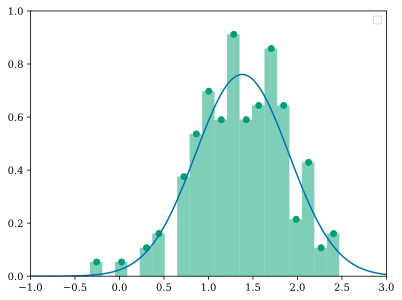

In [82]:
mfit_pop3 = np.linspace(-1, 3, 100)
bin_entries, _, _  = plt.hist(Data_Susa_i, bins=np.linspace(np.log10(Bins_limit_Susa[0]), np.log10(Bins_limit_Susa[1]), 21), alpha = 0.5, density=True)   

mask=(Susa_Y!=0)
Susa_centerf = np.log10(Susa_center)[mask]
plt.scatter(np.log10(Susa_center)[mask], bin_entries[mask])

Susa_popt, Susa_pcov = curve_fit(Gaussian, Susa_centerf, bin_entries[mask], bounds=([0,0],[10, 2]))

plt.plot(mfit_pop3, Gaussian(mfit_pop3, *Susa_popt))
print(Susa_popt) 

plt.ylim(0, 1)
plt.xlim(-1, 3)
plt.legend()

In [83]:
def Susa_IMF_PDF(m, z):
    return Gaussian(np.log10(m), *Susa_popt)

def Susa_IMF_PDF_log(logm, z):
    """
    this pdf is normlaized only for the log of the mass!
    """
    return Gaussian(logm, *Susa_popt)


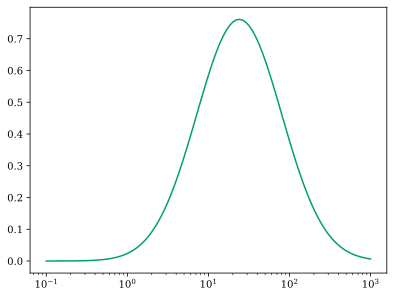

In [84]:
M=np.logspace(-1, 3, 100)
plt.plot(M, Susa_IMF_PDF(M, 10))
plt.xscale('log')

In [270]:
np.log10(0.05)

-1.3010299956639813

In [281]:
def Stacy_PDF(M, z):
    return M**-1.13/3.2066237567908864

def Stacy_PDF_log(M, z):
    return M**-0.13

integrate.quad(Stacy_PDF_log, 0.05, 20, args=1)

(15.488326641696275, 4.5047122656579745e-10)

In [173]:
from scipy.stats import loguniform

def Mass_Star_Generator(ninput, z, PDF, m_interval):
    m_max = np.logspace(np.log10(m_interval[0]),  np.log(m_interval[1]), 100)
    pdfmax = np.max(PDF(m_max, z))
    fmax = pdfmax+0.02*pdfmax
    x_output = np.array([])
    
    ii = 0
    while ii<ninput:

        x = loguniform.rvs(m_interval[0], m_interval[1], size=ninput)
        y = gen.uniform(0, fmax, ninput)

        x_accepted = x[(y <= PDF(x, z))]
        x_output = (np.append(x_output, x_accepted)).flatten()
        ii+=len(x_accepted)
        # print('Mass star', ii)

        x_output = x_output[:ninput]
    
    return x_output


In [180]:
star = Mass_Star_Generator(10000, 10, Susa_IMF_PDF, (0.5, 1000))


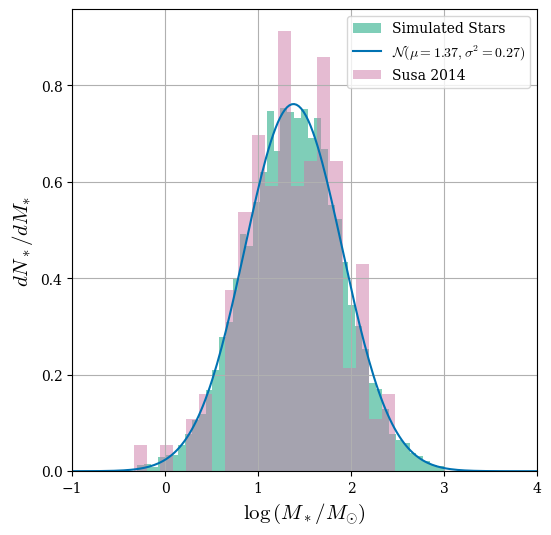

In [232]:
plt.subplots(figsize=(6,6))
plt.grid()
m = np.linspace(-1, 4, 200)
plt.hist(np.log10(star), density=True, bins=45, alpha = 0.5, label = 'Simulated Stars')
# plt.plot(m, Susa_IMF_PDF(m, 10))
plt.plot(m, Susa_IMF_PDF_log(m, 10), label = "$\mathcal{N}(\mu = 1.37, \sigma^2 = 0.27)$")
plt.hist(Data_Susa_i, bins=np.linspace(np.log10(Bins_limit_Susa[0]), np.log10(Bins_limit_Susa[1]), 21), alpha = 0.5, density=True, label = 'Susa 2014')   
plt.xlim(-1,4)
plt.xlabel('$\log{(M_*/M_{\odot})}$')
plt.ylabel('$dN_*/dM_{*}$')
# plt.xscale('log')
plt.legend()
plt.savefig(path_image+'Susa_Datas.png', dpi=500)


[0.28944217 0.3859229  1.10952833 1.35073014 0.96480725 0.14472109
 0.09648072 0.43416326 0.53064398 0.53064398 1.20600906 0.57888435
 0.91656688 0.67536507 0.43416326 0.14472109 0.09648072 0.09648072
 0.         0.        ]
[0.02097848 0.04195695 0.16782781 0.14684934 0.10489238 0.20978477
 0.08391391 0.18880629 0.31467715 0.67131126 1.02794537 1.46849338
 1.48947186 2.20274007 1.1747947  0.46152649 0.14684934 0.06293543
 0.         0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.14214598 0.14214598 0.24875546 0.46197443 1.06609484
 1.3148503  2.34540864 2.6297006  1.3148503  0.21321897 0.10660948
 0.         0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.21246287 0.31869431 0.42492574
 0.53115718 1.27477723 4.143026   2.23086016 0.63738862 0.21246287
 0.         0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0

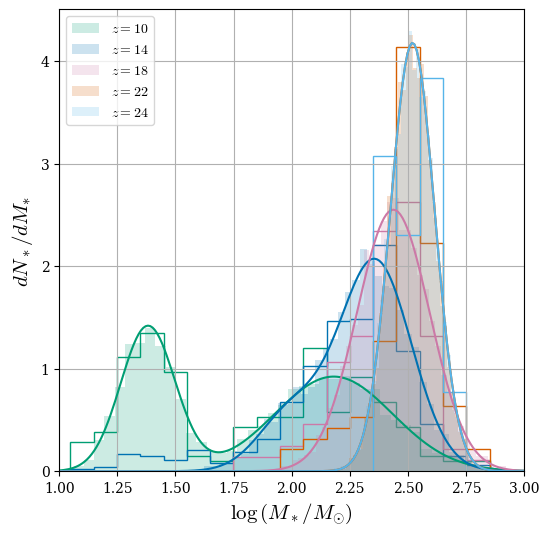

In [260]:
z = [10, 14, 18, 22, 24]
plt.subplots(figsize=(6,6))
plt.grid()
m = np.logspace(1, 3, 200)
for i in range(len(z)):
    star_hirano = Mass_Star_Generator(10000, z[i], Hirano2015_pdf, (10, 1000))
    plt.hist(np.log10(star_hirano), density=True, bins=45, alpha = 0.2, color = myColors[i], label = f'$z = {z[i]}$')
    plt.plot(np.log10(m), Hirano2015_pdf(m, z[i]), color = myColors[i])
    hist, bin_edges = np.histogram(Data_Hirano2015 [i+1], bins=np.linspace(np.log10(Bins_limit_Hirano2015[0]), np.log10(Bins_limit_Hirano2015[1]), 21), density=True)   
    plt.stairs(hist, bin_edges, color = myColors[i])
plt.xlim(1,3)
plt.xlabel('$\log{(M_*/M_{\odot})}$')
plt.ylabel('$dN_*/dM_{*}$')
# plt.xscale('log')
plt.legend()
plt.savefig(path_image+'hirano_Datas.png', dpi=500)

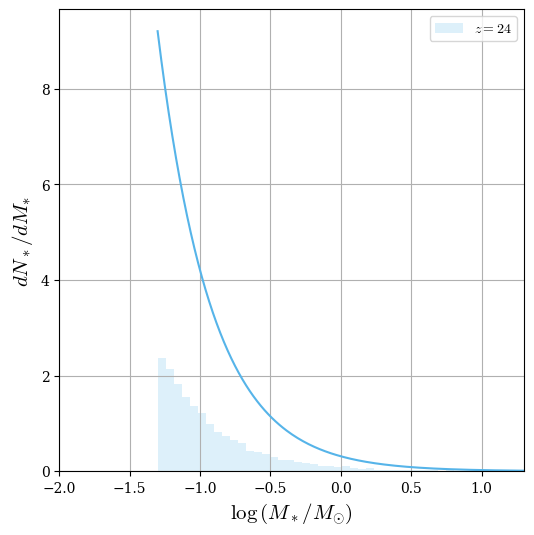

In [288]:

plt.subplots(figsize=(6,6))
plt.grid()
m = np.logspace(np.log10(0.05), np.log10(20), 200)
star_stacy = Mass_Star_Generator(10000, z[i], Stacy_PDF, (0.05, 20))
plt.hist(np.log10(star_stacy), density=True, bins = 45, alpha = 0.2, color = myColors[i], label = f'$z = {z[i]}$')
plt.plot(np.log10(m), Stacy_PDF(m, z[i]), color = myColors[i])
plt.xlim(np.log10(0.01), np.log10(20))
plt.xlabel('$\log{(M_*/M_{\odot})}$')
plt.ylabel('$dN_*/dM_{*}$')
# plt.xscale('log')
# plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.savefig(path_image+'hirano_Datas.png', dpi=500)

46 44


(1000000.0, 100000000000.0)

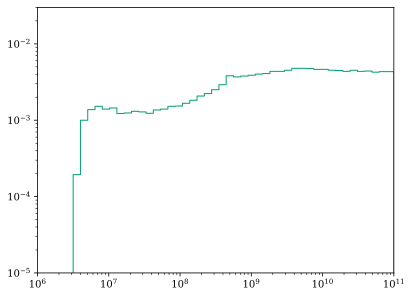

In [219]:
path_tanikawa = '/Users/antoninpantalacci/Desktop/Master Project/Papernotes and Books/Graph/Fit/'

Tanikawa = np.genfromtxt(path_tanikawa + 'Tanikawa' +'.csv', delimiter=';')
Bins_loglimit_Tanikawa = (6.5, 11)
Nbins_Tanikawa= 20
Tanikawa2 = Tanikawa[1: -1]
print(len(Tanikawa), len(Tanikawa2))
plt.stairs(Tanikawa2[:,1], np.logspace(6.5, 11, 45))
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5, 3e-2)
plt.xlim(1e6, 1e11)

In [89]:
H0= (67.66 * u.km * u.s**-1 * u.Mpc**-1).to(u.yr**-1).value
omega_m = 0.3103
omega_l = 0.6897
Rsun = 696340*u.km
Msun= constants.M_sun
c=constants.c.to(u.km/u.s)
G=constants.G.to(u.km**3/u.s**2/u.kg)

In [90]:
@njit
def Time_z(z):
    a = 1/(1 + z)
    denom = H0*3*np.sqrt(a * omega_l * (a**3 * omega_l + omega_m) / a)
    num = 2 * np.sqrt(a**3 * omega_l + omega_m) * np.arctanh(np.sqrt(a**3 * omega_l / (a**3 * omega_l + omega_m)))

    return num / denom

@njit
def Redshift_t(t):
    denom = (omega_l - omega_l * np.tanh(3 / 2 * H0 * t * np.sqrt(omega_l))**2)**(1/3)
    num = omega_m**(1/3) * np.tanh(3 / 2 * H0 * t * np.sqrt(omega_l))**(2/3)
    return denom/num-1

_ = Time_z(30)
_ = Redshift_t(3000000000)


In [92]:
import math
norm_a = integrate.quad(lambda k: 1/k, 6957000, 2000*695700)[0]
# norm = integrate.quad(lambda k: k**-1, 0, np.inf)[0]

def a_pdf(x):
    return 1/x/5.298317366548035

def a_generator(n, amin):
    amin = amin
    fmax = a_pdf(amin)+0.01*a_pdf(amin)
    ii=0
    x_output=np.array([])
    while ii<n:
        y = np.random.uniform(0, fmax, 1000)
        x = np.random.uniform(amin, 2000*695700, 1000)
        mask = y<a_pdf(x)
        x_output = np.append(x_output, x[mask])
        ii+=len(x[mask])
    return x_output[:n][0]

def e_pdf(e, ai, amin):
    return e/(1/2 * math.pow((1 - amin/ai), 2))

def e_generator(n, ai, amin):
    emax = 1 - amin/ai
    fmax = 2/emax+0.01*2/emax
    ii=0
    x_output=np.array([])
    while ii<n:
        y = np.random.uniform(0, fmax, 1000)
        x = np.random.uniform(0, emax, 1000)
        mask = y<e_pdf(x, ai, amin)
        x_output = np.append(x_output, x[mask])
        ii+=len(x[mask])
    return x_output[:n][0]

_ = a_pdf(1000000)
_ = e_pdf(0.9, 7000000, 10*695700)

In [93]:
@njit
def g_e(e):
    return (1-e**2)**(7/2)/(1+(73/24)*e**2+(37/96)*e**4)


def Merging_Time(M1, M2):

    M1 = max((M1, M2))
    M2 = min((M1, M2))

    M1 = M1*Msun
    M2 = M2*Msun

    q= (M2/M1).value

    R1 = (0.28*Rsun*(M1/Msun)**0.61)

    amin2 = ((0.6 * math.pow(q, 2/3) + np.log(1 + math.pow(q, 1/3))) / (0.49 * math.pow(q, 2/3)) * R1 / Rsun).value
    
    amin= max((6957000., amin2))

    a = a_generator(1, amin)
    e = e_generator(1, a, amin)
    
    t = (((5/256) * (c**5/G**3*(a*u.km)**4)/(M1*M2*(M1+M2))*g_e(e)).to(u.yr)).value + 1e2
    return t

_ = g_e(0.9)
_ = Merging_Time(1e6, 1e6)


In [358]:
def Redshift_routine(z_i, z_f, dt):

    t_i = Time_z(z_i)
    t_f = Time_z(z_f)
    
    def redhsift_steps(step_number, dt, n_step):
        if step_number <= n_step:
            steped_time = t_i + step_number*dt
            return Redshift_t(steped_time)
        else:
            return False

    n_step = int(np.rint((t_f - t_i)/dt))
    print('There will be ', n_step, 'steps')
    z = []
    simulation_finished = True

    i = 0
    while simulation_finished:
        simulation_finished = redhsift_steps(i, dt, n_step)
        z.append(simulation_finished)
        if not simulation_finished:
            z = z[:-2]
        i+=1

    return z

def Routine(z, PopIII_PDF, f, m_interval):
    
    M1_z = []
    M2_z = []
    z_merge = []
    t_merge = []
    t_coas_merge = []
    chirp_mass_z = []


    for i in range(len(z)):
        Halos = HalosGenerator(1e9, z[i])
        Ns = N_StarGenerator(Halos, f)
        m_popIIIs = []
        for n in Ns:
            m_popIIIs = np.concatenate((m_popIIIs, Mass_Star_Generator(n, z[i], PopIII_PDF, (m_interval[0], m_interval[1])).tolist()))

        n = len(m_popIIIs)

        M1=[]
        M2=[]
        binaries = []
        z_binaries = []
        chirp_mass = []
        t_binaries = []
        
        for s in range(int(n/4)):
            M1.append(m_popIIIs[2*s])
            M2.append(m_popIIIs[2*s+1])
            
            binaries.append(Merging_Time(m_popIIIs[2*s], m_popIIIs[2*s+1]))
            z_binaries.append(Redshift_t(Time_z(z[i])+binaries[-1]))
            t_binaries.append(Time_z(z[i])+binaries[-1])
            chirp_mass.append((m_popIIIs[2*s]*m_popIIIs[2*s+1])**(3/5)/(m_popIIIs[2*s]+m_popIIIs[2*s+1])**(1/5))

        chirp_mass_z.append(chirp_mass)
        M1_z.append(M1)
        M2_z.append(M2)
        t_coas_merge.append(np.array(binaries)[np.array(binaries) < Time_z(0)].tolist())
        z_merge.append(np.array(z_binaries)[np.array(binaries) < Time_z(0)].tolist())
        t_merge.append(t_binaries)

        # t_coas_merge.append(binaries)
        # z_merge.append(z_binaries)
        
    return M1_z, M2_z, z_merge, t_merge, t_coas_merge, chirp_mass_z

In [508]:
def Computer(f, dt, zi, zf, IMF, IMF_born):

    z = Redshift_routine(zi, zf, dt)

    M1_z, M2_z, z_merge, t_merge, t_coas_merge, chirp_mass_z = Routine(z, IMF, f, IMF_born)

    merge_z_datas = np.concatenate(z_merge) 
    merge_t_datas = np.concatenate(t_merge) 
    chirp_mass = np.concatenate(chirp_mass_z) 

    coal_time_datas = np.log10(np.concatenate(t_coas_merge))
    coal_nbins = int(3*np.ceil(np.log2(len(coal_time_datas))) + 1)
    hist, bins_edges = np.histogram(coal_time_datas, bins=coal_nbins, density=True)
    gamma = hist/len(hist)

    return chirp_mass, merge_z_datas, merge_t_datas, gamma, bins_edges

There will be  17 steps
There will be  8 steps


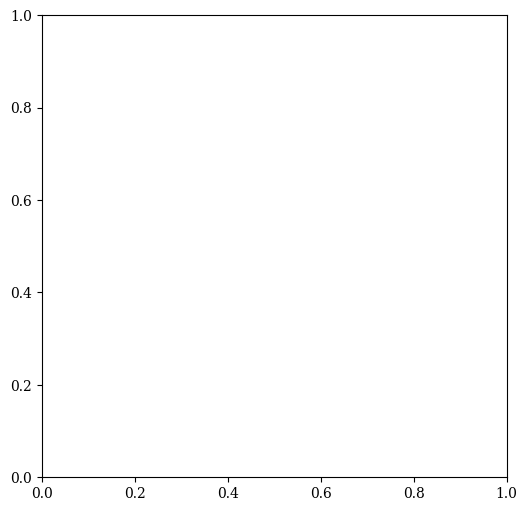

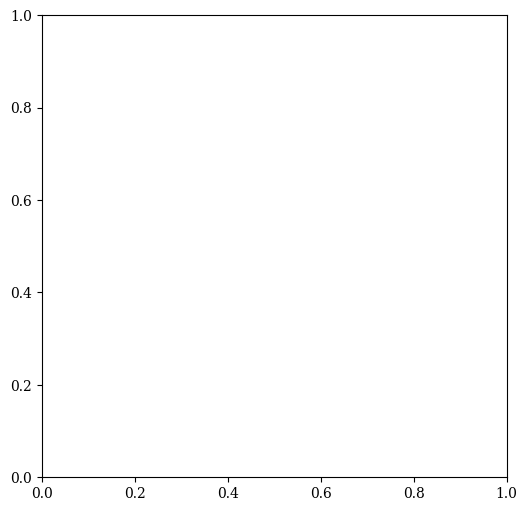

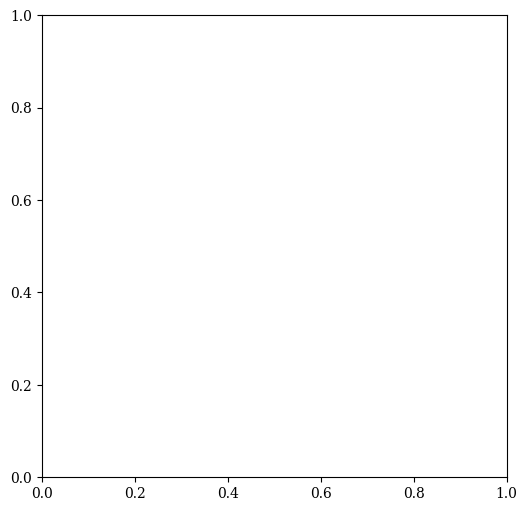

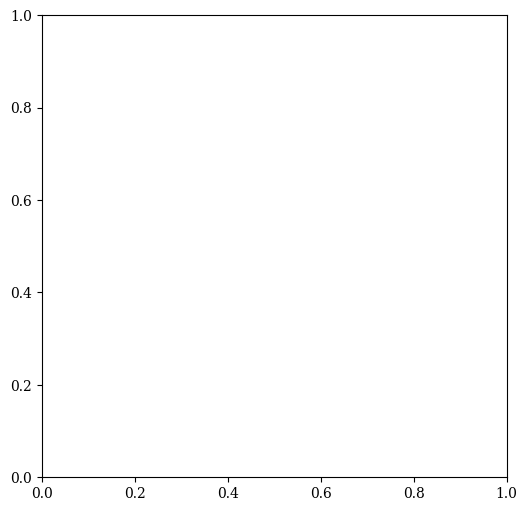

In [347]:
fig1, ax = plt.subplots(figsize=(6,6))
fig2, bx = plt.subplots(figsize=(6,6))
fig3, cx = plt.subplots(figsize=(6,6))
fig4, dx = plt.subplots(figsize=(6,6))


In [420]:
from lmfit import Model

In [499]:
def PL_time(x, a, b):
    return a*x+b

def output(chirps, zs, ts, gammas, binedges, label_change, colors):

    bin_centers = np.sqrt(binedges[1:] * binedges[:-1])
    ts_nbins = int(3*np.ceil(np.log2(len(ts))) + 1)
    entries, edges, _  = ax.hist(ts, bins = np.logspace(8, 14, ts_nbins), density=True, alpha = 0.5, label = label_change, color = colors)
    
    centers = np.log(np.array([0.5 * (edges[i] + edges[i+1]) for i in range(len(entries))]))
    entries = np.log(entries)

    mask = (entries < 1e9) & (entries > -1e30)
    centers = centers[mask]
    entries = entries[mask]

    print(entries)
    
    gmodel = Model(PL_time)
    result = gmodel.fit(entries, x=centers, a=-1.3, b=-0.5) 
    # for key in result.params:
    #     print(key, "=", result.params[key].value, "+/-", result.params[key].stderr)  

    # ax.plot(np.exp(centers), np.exp(result.init_fit),'r--')
    ax.plot(np.exp(centers), np.exp(result.best_fit),  color = colors, label = r"fit, $\alpha =$" +f"{round(result.params['a'].value,2)}")

    zs_nbins = int(3*np.ceil(np.log2(len(zs))) + 1)
    bx.hist(zs, zs_nbins, density=True, alpha = 0.5, label = label_change, color = colors)
    cx.bar(bin_centers, gammas, width=np.diff(binedges), align='center', alpha = 0.5, label = label_change, color = colors)
    chirps_nbins = int(3*np.ceil(np.log2(len(chirps))) + 1)
    dx.hist(chirps, bins = np.logspace(0, 2.5, chirps_nbins), density = True, alpha = 0.5, label = label_change, color = colors)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r"$t_{BH-BH}$ $[$yr$]$")
    ax.set_ylabel(r'$\frac{dN_{BH-BH}}{dt_{BH-BH}}$')
    ax.legend()

    bx.set_xlabel('$z_{BH-BH}$')
    bx.set_ylabel(r'$\frac{dN_{BH-BH}}{dz_{BH-BH}}$')
    bx.legend()

    cx.set_xlabel(r'$\log{\tau}$')
    cx.set_ylabel(r'$\frac{dN_{BH-BH}/d\log{t}}{N_{bin}}$')
    cx.set_yscale('log')
    cx.set_ylim(1e-5, 1e-1)
    cx.set_xlim(3.5, 11)
    
    dx.set_xlabel(r'$t_{coal}$')
    dx.set_ylabel(r'$\frac{dN_{BH-BH}}{dt_{coal}}$')
    dx.set_xscale('log')
    dx.legend()

In [500]:
f = 1
dt = 1e7
zi = 30

chirps_Susa = []
zs_Susa = []
ts_Susa =[]
gammas_Susa = []
binedges_Susa = []


for i in range(1,3):
    
    zf = 10+5*i

    chirp_mass, merge_z_datas, merge_t_datas, gamma, bins_edges = Computer(f, dt, zi, zf, Susa_IMF_PDF, (0.1, 1000))

    chirps_Susa.append(chirp_mass)
    zs_Susa.append(merge_z_datas)
    ts_Susa.append(merge_t_datas)
    gammas_Susa.append(gamma)
    binedges_Susa.append(bins_edges)

There will be  17 steps
There will be  8 steps


[-21.3865031  -20.60914099 -21.74825662 -22.67672427 -23.64256817
 -24.13120307 -24.78256117 -25.35820744 -26.07868466 -26.48727685
 -27.29711651 -27.97504163 -28.30623457 -29.12633418 -29.54563438
 -30.37447655 -31.15645926 -31.39861392 -32.06807895 -32.69415608
 -33.59257574 -33.79501777 -34.81797626 -35.25052169]
[-20.1767956  -21.69651985 -22.52342755 -23.42184244 -24.11261797
 -24.57513484 -25.72374347 -26.67045237 -26.90169557 -27.76432135
 -28.55353695 -29.47611409 -30.16688962 -30.66095485 -31.50588106
 -31.81936236 -33.02096351 -33.98367275 -34.04583962 -35.00231832]


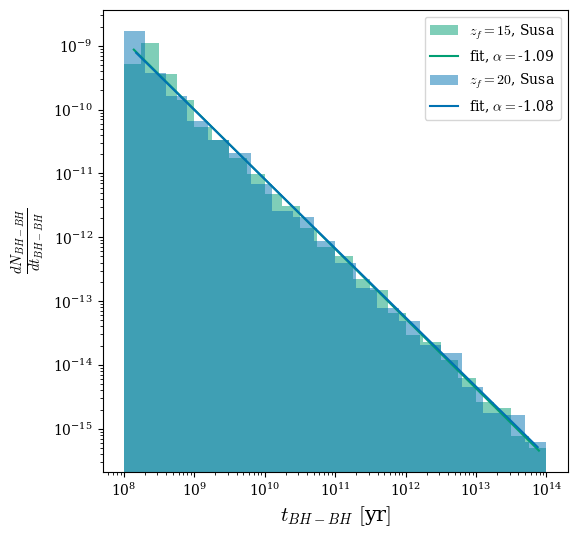

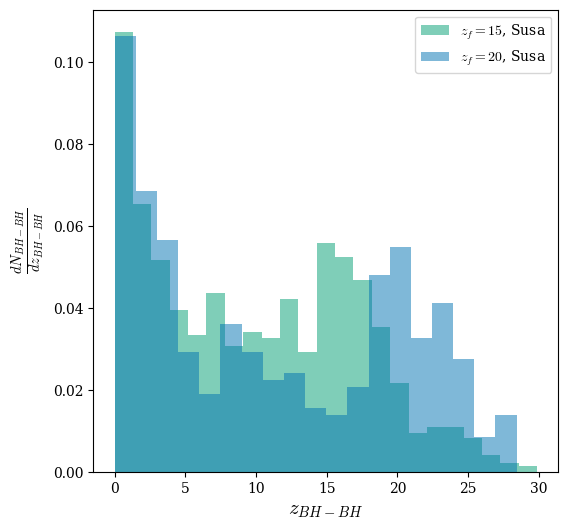

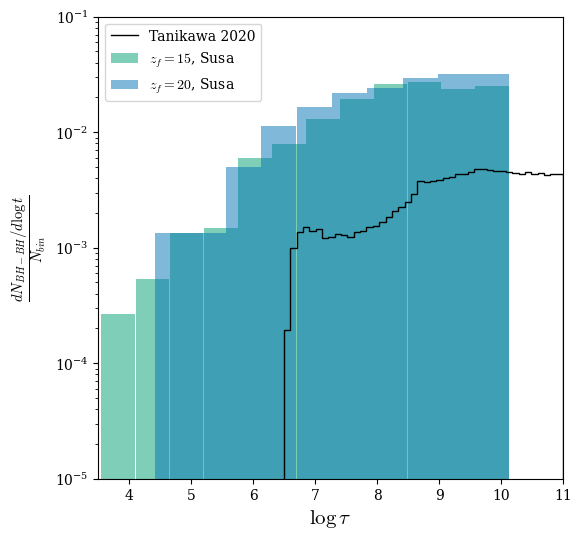

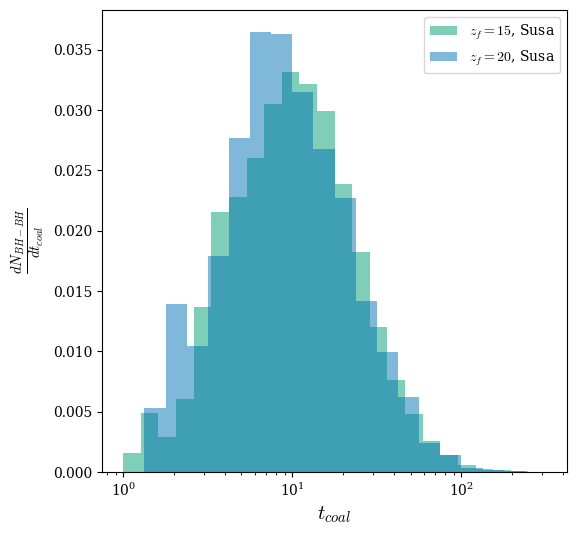

In [501]:
fig1, ax = plt.subplots(figsize=(6,6))
fig2, bx = plt.subplots(figsize=(6,6))
fig3, cx = plt.subplots(figsize=(6,6))
fig4, dx = plt.subplots(figsize=(6,6))


for i in range(len(chirps_Susa)):
    zf = 10+5*(i+1)
    output(chirps_Susa[i], zs_Susa[i], ts_Susa[i], gammas_Susa[i], binedges_Susa[i], f"$z_f = {zf}$, Susa", colors = myColors[i])

cx.stairs(Tanikawa2[:,1], np.linspace(6.5, 11, 45), color = 'k', label = 'Tanikawa 2020')
cx.legend()

In [504]:
f = 1
dt = 1e7
zi = 30
zf=15

chirps_Susa = []
zs_Susa = []
ts_Susa =[]
gammas_Susa = []
binedges_Susa = []


for i in range(0,3):
    
    f = 1/10**(2*i)

    chirp_mass, merge_z_datas, merge_t_datas, gamma, bins_edges = Computer(f, dt, zi, zf, Susa_IMF_PDF, (0.1, 1000))

    chirps_Susa.append(chirp_mass)
    zs_Susa.append(merge_z_datas)
    ts_Susa.append(merge_t_datas)
    gammas_Susa.append(gamma)
    binedges_Susa.append(bins_edges)

There will be  17 steps
There will be  17 steps
There will be  17 steps


[-21.14525179 -20.58221879 -21.96277116 -22.71534814 -23.46688508
 -24.15432276 -24.80822123 -25.69508007 -26.00714183 -26.64570192
 -27.20844479 -27.86413377 -28.38571283 -29.14895771 -29.59107259
 -30.34904042 -30.9246867  -31.46754315 -32.07597924 -32.89582248
 -33.27856508 -33.70760788 -34.50261699 -35.43763726]
[-20.15207268 -20.85695776 -21.79152843 -22.5377933  -23.10865082
 -23.67386772 -24.23168321 -24.71230095 -25.20783293 -25.76253234
 -26.3630612  -26.80266959 -27.40940936 -27.91354442 -28.32670548
 -28.89499024 -29.40734642 -29.99524836 -30.55059875 -30.92942681
 -31.58318055 -32.10028141 -32.59712304 -33.09397647 -33.54024078
 -34.3940933  -34.87345264 -35.23217022]
[-20.11767112 -20.78553054 -21.65508198 -22.40526954 -22.92990054
 -23.45348574 -23.94709401 -24.46730151 -24.94785928 -25.46672618
 -26.0006911  -26.3942188  -26.91941834 -27.41510897 -27.94223507
 -28.36029877 -28.8709516  -29.34180463 -29.87224259 -30.30257899
 -30.83886857 -31.41026829 -31.86429178 -32.315

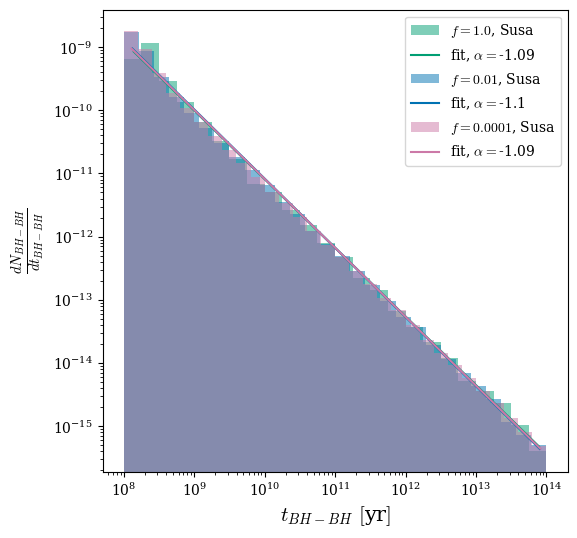

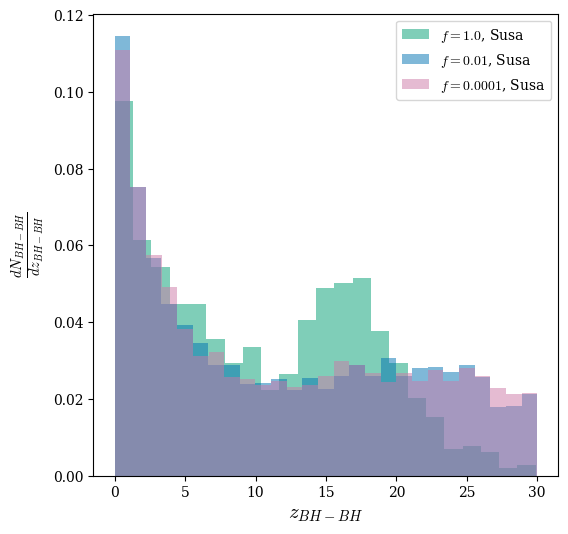

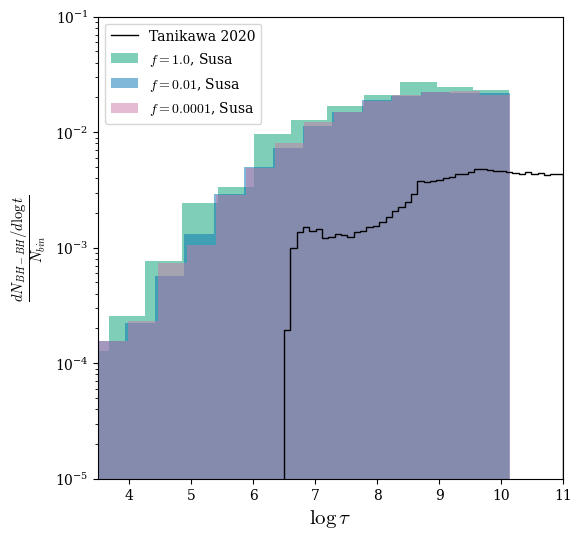

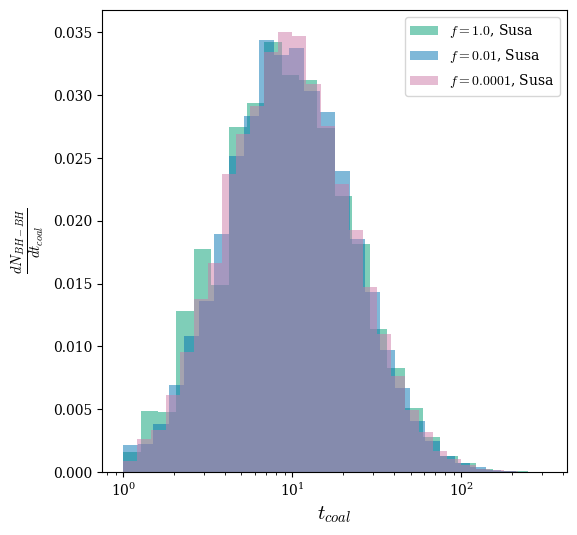

In [505]:
fig1, ax = plt.subplots(figsize=(6,6))
fig2, bx = plt.subplots(figsize=(6,6))
fig3, cx = plt.subplots(figsize=(6,6))
fig4, dx = plt.subplots(figsize=(6,6))


for i in range(len(chirps_Susa)):
    f = 1/10**(2*i)
    output(chirps_Susa[i], zs_Susa[i], ts_Susa[i], gammas_Susa[i], binedges_Susa[i], f"$f = {f}$, Susa", colors = myColors[i])

cx.stairs(Tanikawa2[:,1], np.linspace(6.5, 11, 45), color = 'k', label = 'Tanikawa 2020')
cx.legend()

In [506]:
f = 1

zi = 30
zf=20

chirps_Susa = []
zs_Susa = []
ts_Susa =[]
gammas_Susa = []
binedges_Susa = []


for i in range(6,9):

    dt = 10**i

    chirp_mass, merge_z_datas, merge_t_datas, gamma, bins_edges = Computer(f, dt, zi, zf, Susa_IMF_PDF, (0.1, 1000))

    chirps_Susa.append(chirp_mass)
    zs_Susa.append(merge_z_datas)
    ts_Susa.append(merge_t_datas)
    gammas_Susa.append(gamma)
    binedges_Susa.append(bins_edges)

There will be  80 steps
There will be  8 steps
There will be  1 steps


[-20.44828741 -20.60648202 -21.74300433 -22.50698055 -23.1136159
 -23.62770719 -24.17005771 -24.73156642 -25.36911142 -25.84332806
 -26.28127207 -26.97735426 -27.30846671 -27.85969737 -28.39774061
 -28.91211683 -29.42694202 -29.9378208  -30.52830574 -31.01205493
 -31.5347364  -32.09997322 -32.44533122 -33.08149036 -33.76040266
 -34.07361759 -34.86899671 -35.34812185]
[-20.32780725 -21.50860528 -22.39353682 -23.44610239 -24.18952165
 -24.93586703 -25.59847168 -26.18388669 -26.98002274 -27.85311982
 -28.36157379 -29.0805202  -30.28212135 -30.65012348 -31.66367241
 -32.22091654 -32.68854852 -33.6024676  -34.47556468 -35.02657827]
[-21.56674864 -22.71804118 -23.46386862 -26.40692064 -25.76645371
 -27.32321137 -28.76218599 -29.40265291 -32.16338337 -31.92838156
 -34.46596846 -34.23096665]


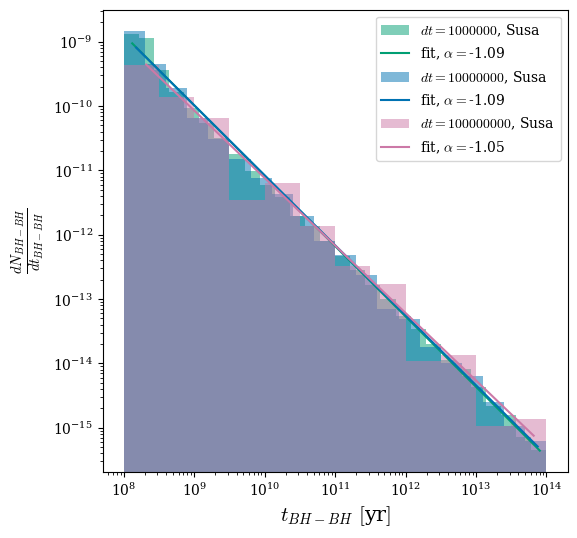

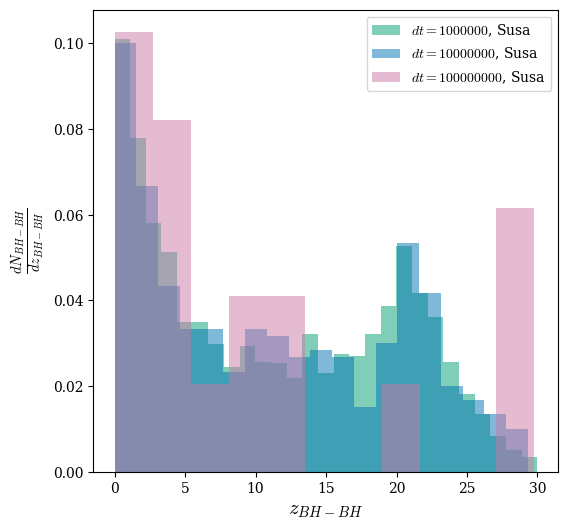

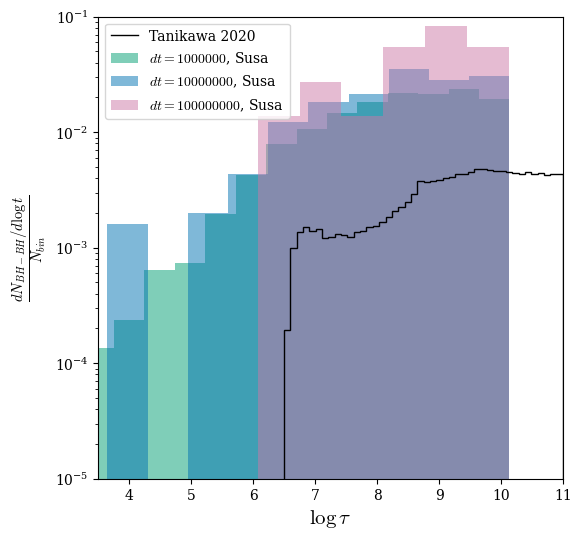

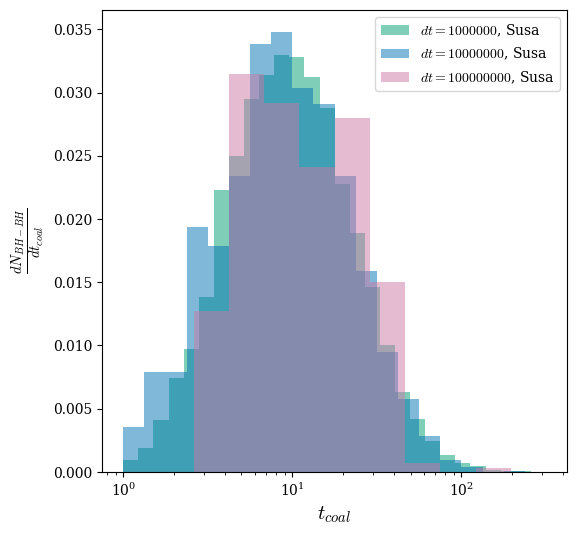

In [507]:
fig1, ax = plt.subplots(figsize=(6,6))
fig2, bx = plt.subplots(figsize=(6,6))
fig3, cx = plt.subplots(figsize=(6,6))
fig4, dx = plt.subplots(figsize=(6,6))


for i in range(len(chirps_Susa)):
    dt = 10**(6+i)
    output(chirps_Susa[i], zs_Susa[i], ts_Susa[i], gammas_Susa[i], binedges_Susa[i], f"$dt = {dt}$, Susa", colors = myColors[i])

cx.stairs(Tanikawa2[:,1], np.linspace(6.5, 11, 45), color = 'k', label = 'Tanikawa 2020')
cx.legend()

In [386]:
dt = 1e7
zi = 30
zf=10

chirps_H = []
zs_H = []
ts_H =[]
gammas_H = []
binedges_H = []


for i in range(0,3):
    
    f = 1/10**(2*i)

    chirp_mass, merge_z_datas, merge_t_datas, gamma, bins_edges = Computer(f, dt, zi, zf, Hirano2015_pdf, (10**0.5, 10**3.5))

    chirps_H.append(chirp_mass)
    zs_H.append(merge_z_datas)
    ts_H.append(merge_t_datas)
    gammas_H.append(gamma)
    binedges_H.append(bins_edges)



There will be  37 steps
There will be  37 steps
There will be  37 steps


[-20.76319137 -20.33806001 -20.5709646  -22.30727833 -23.37833772
 -24.01552904 -24.80554507 -25.51442471 -25.89886007 -26.4117638
 -27.02571618 -27.74604807 -28.35213741 -28.6883335  -29.40628525
 -29.89580393 -30.5307104  -31.21926177 -31.71921137 -32.37094084
 -32.79230574 -33.62533984 -34.37633424 -34.98045939 -35.6754546
 -36.32460343]
[-18.86043189 -20.41422647 -21.67059106 -22.70501275 -23.5436439
 -24.13008986 -24.62600408 -25.1603416  -25.66425148 -26.32687778
 -26.80478468 -27.31369996 -27.86169924 -28.35841612 -28.96383227
 -29.48732082 -30.03564767 -30.65799244 -31.3768433  -31.83081266
 -32.3752263  -33.18781813 -33.86515206 -34.68546594 -35.85877899
 -36.85428202 -37.77513713 -38.67401333]
[-18.82133776 -20.23473771 -21.49171953 -22.46533232 -23.28211852
 -23.9245515  -24.41470031 -24.96977591 -25.46106459 -25.96810163
 -26.41678419 -26.95367418 -27.45965358 -27.98183396 -28.38735431
 -29.01098063 -29.35284011 -29.89339983 -30.52718857 -31.07226298
 -31.70923643 -32.19342

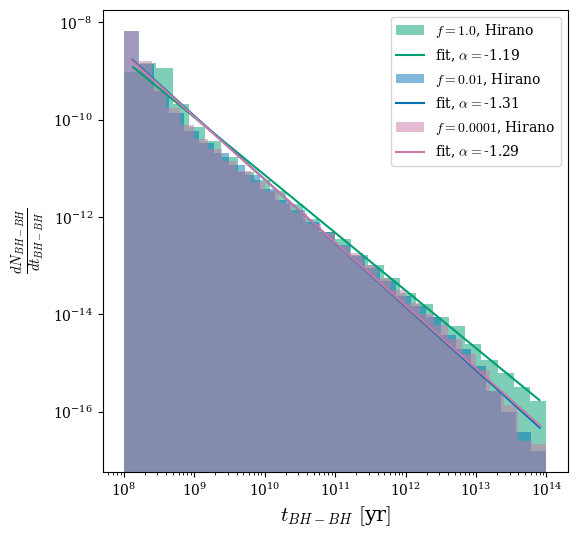

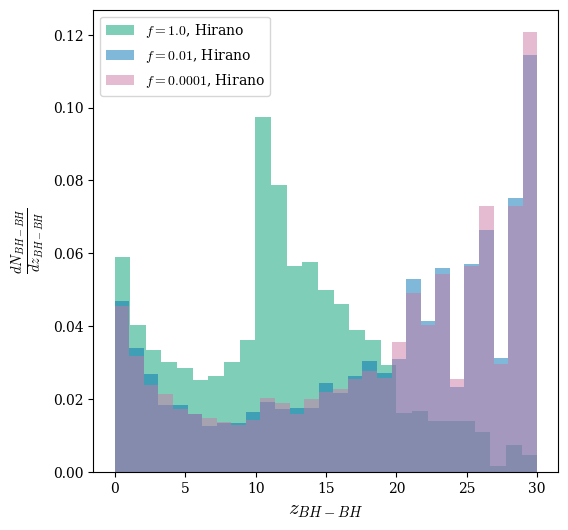

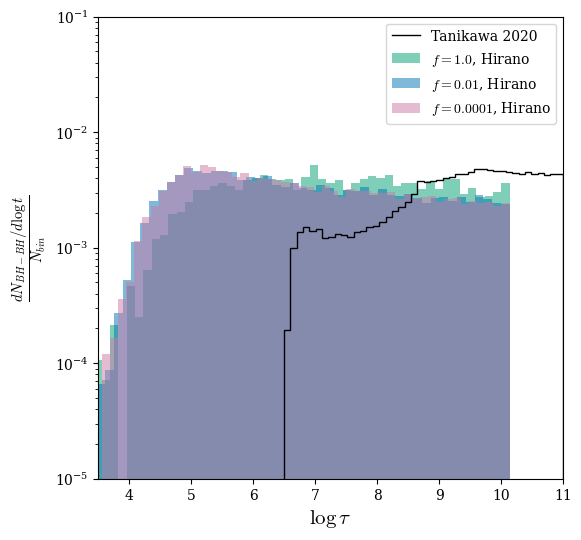

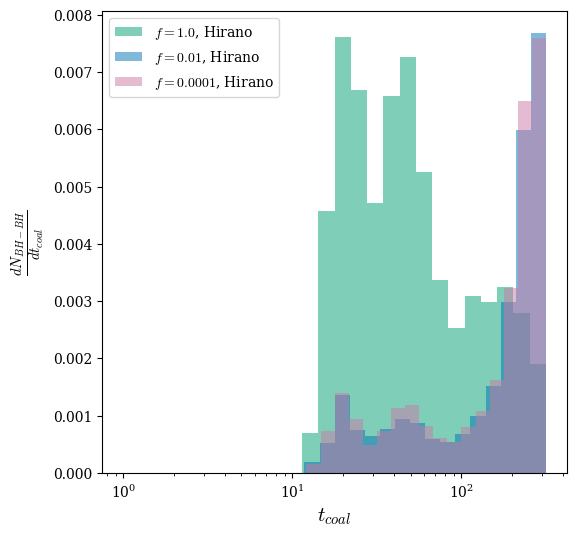

In [484]:
fig1, ax = plt.subplots(figsize=(6,6))
fig2, bx = plt.subplots(figsize=(6,6))
fig3, cx = plt.subplots(figsize=(6,6))
fig4, dx = plt.subplots(figsize=(6,6))


for i in range(len(chirps_H)):
    f = 1/10**(2*i)
    output(chirps_H[i], zs_H[i], ts_H[i], gammas_H[i], binedges_H[i], f"$f = {f}$, Hirano", colors = myColors[i])

cx.stairs(Tanikawa2[:,1], np.linspace(6.5, 11, 45), color = 'k', label = 'Tanikawa 2020')
cx.legend()

In [462]:
f = 1
dt = 1e7
zi = 30

chirps_Stacy = []
zs_Stacy = []
ts_Stacy =[]
gammas_Stacy = []
binedges_Stacy = []

for i in range(1,3):
    
    zf = 10+5*i

    chirp_mass, merge_z_datas, merge_t_datas, gamma, bins_edges = Computer(f, dt, zi, zf, Stacy_PDF, (0.5, 20))

    chirps_Stacy.append(chirp_mass)
    zs_Stacy.append(merge_z_datas)
    ts_Stacy.append(merge_t_datas)
    gammas_Stacy.append(gamma)
    binedges_Stacy.append(bins_edges)

There will be  17 steps
There will be  8 steps


[-26.25861769 -26.83426396 -27.40991024 -26.3761186  -26.95176487
 -27.19093891 -27.40991024 -27.80323495 -27.77274542 -28.22055833
 -28.54934452 -29.00720776 -29.38218334 -29.59888452 -30.14327825
 -30.45066053 -30.70678413 -31.2162906  -32.05590242 -32.64201999
 -33.24975458 -33.83632992]
[0.02414933 0.         0.         0.         0.         0.
 0.         0.         0.02414933 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.02414933 0.         0.         0.
 0.04829867 0.04829867 0.         0.02414933 0.         0.
 0.02414933 0.02414933 0.         0.02414933 0.02414933 0.
 0.         0.         0.04829867 0.         0.02414933 0.
 0.072448   0.         0.         0.02414933 0.02414933 0.02414933
 0.         0.09659733]
[-25.83059264 -26.52136816 -26.80667858 -27.49745411 -27.20740039
 -27.4126681  -27.723954   -28.52595517 -28.91444982 -29.40851506
 -29.93498753 -30.62576306 -30.84275424 -31.71963205 -32.36595581
 -33.0

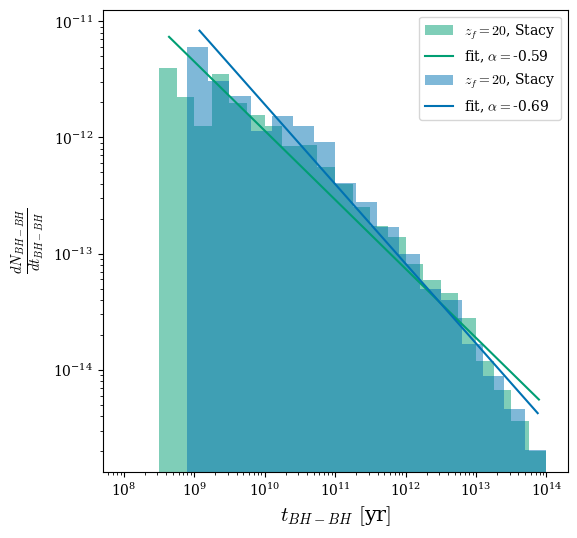

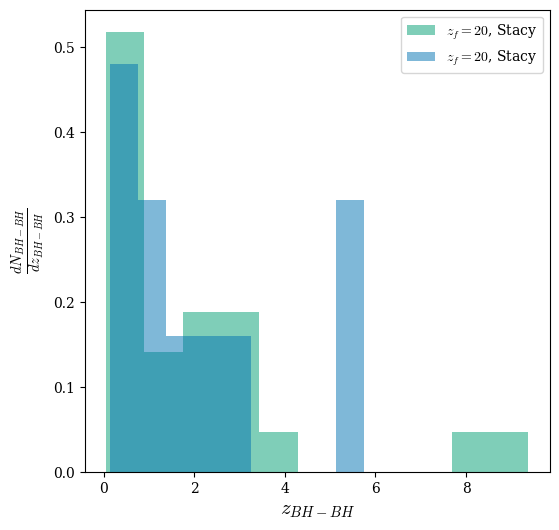

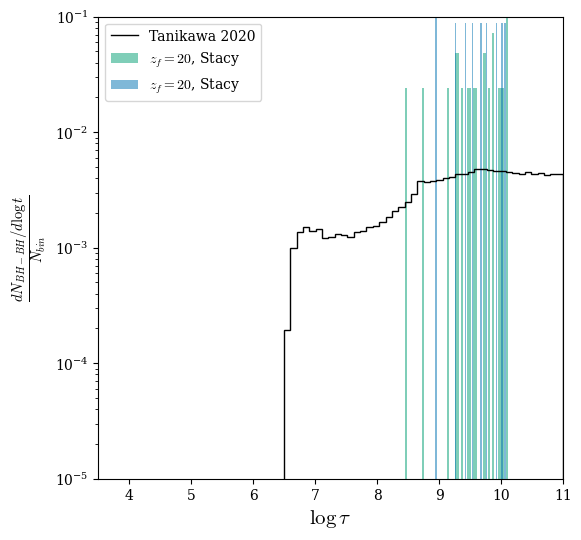

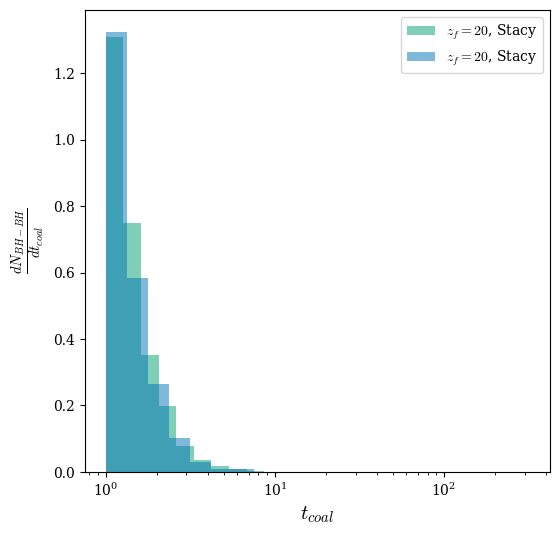

In [490]:
fig1, ax = plt.subplots(figsize=(6,6))
fig2, bx = plt.subplots(figsize=(6,6))
fig3, cx = plt.subplots(figsize=(6,6))
fig4, dx = plt.subplots(figsize=(6,6))


for i in range(len(chirps_Stacy)):
    f = 1/10**(2*i)
    output(chirps_Stacy[i], zs_Stacy[i], ts_Stacy[i], gammas_Stacy[i], binedges_Stacy[i], f"$z_f = {zf}$, Stacy", colors = myColors[i])

cx.stairs(Tanikawa2[:,1], np.linspace(6.5, 11, 45), color = 'k', label = 'Tanikawa 2020')
cx.legend()